# Timon Spichtinger Machine Learning 2 Modularbeit

In [1]:
from torchvision.datasets import EMNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch
import importlib
from Datensatz import get_emnist_test_train, show_random_samples

In [2]:
X_train, y_train, X_test, y_test,classlist = get_emnist_test_train()

Ziel-ASCII: [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
Anzahl Zielklassen: 36
⚠️ Klasse B: nur 3878 echte Bilder – augmentiere 2122 zusätzlich.
⚠️ Klasse D: nur 4562 echte Bilder – augmentiere 1438 zusätzlich.
⚠️ Klasse E: nur 4934 echte Bilder – augmentiere 1066 zusätzlich.
⚠️ Klasse G: nur 2517 echte Bilder – augmentiere 3483 zusätzlich.
⚠️ Klasse H: nur 3152 echte Bilder – augmentiere 2848 zusätzlich.
⚠️ Klasse J: nur 3762 echte Bilder – augmentiere 2238 zusätzlich.
⚠️ Klasse K: nur 2468 echte Bilder – augmentiere 3532 zusätzlich.
⚠️ Klasse L: nur 5076 echte Bilder – augmentiere 924 zusätzlich.
⚠️ Klasse b: nur 5159 echte Bilder – augmentiere 841 zusätzlich.
⚠️ Klasse c: nur 2854 echte Bilder – augmentiere 3146 zusätzlich.
⚠️ Klasse f: nur 2561 echte Bilder – augmentiere 3439 zusätzlich.
⚠️ Klasse g: nur 3687 echte Bilder – augmentiere 2313 zusätzlich.
⚠️ Klasse i: nur 272

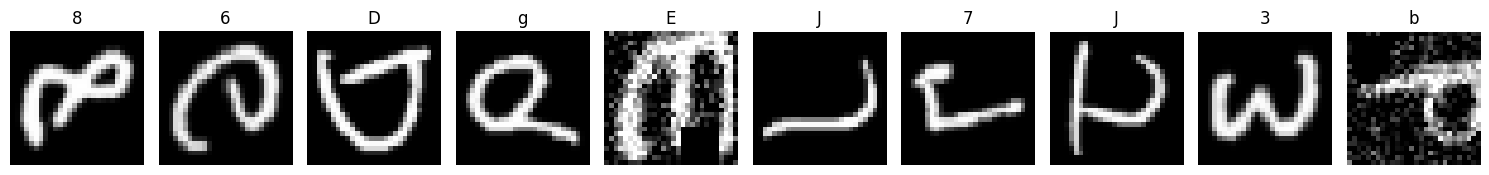

In [3]:

show_random_samples(X_test, y_test, classlist, n=10)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from collections import defaultdict
import optuna
from Klassifikator import get_objective, ResNet18, EarlyStopping

# Gerät
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Klassenliste (36 Klassen)
class_list = list('0123456789ABCDEFGHIJKLMabcdefghijklm')

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)





# -----------------------------
# Optuna-Ziel-Funktion
# -----------------------------
"""
def objective(trial):
    # Hyperparameter-Sampling
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 144, 256])
    lr = trial.suggest_float("lr", 1e-4, 0.1, log=True)
    momentum = trial.suggest_float("momentum", 0.6, 0.95)
    step_size = trial.suggest_int("step_size", 2, 5)
    gamma = trial.suggest_float("gamma", 0.5, 0.95)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = ResNet18(num_classes=len(class_list)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    early_stopping = EarlyStopping(patience=4)

    for epoch in range(20):  # ggf. mehr bei finalem Training
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()

        # Validierungs-Loss berechnen
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
        val_loss /= len(test_loader)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"⛔ Early Stopping in Epoch {epoch+1}")
            break
        print(f"📉 Epoch {epoch+1}: Val Loss = {val_loss:.4f}")


    # Genauigkeit auf Testdaten
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy
"""

# -----------------------------
# Optuna-Studie starten
# -----------------------------
study = optuna.create_study(direction="maximize")
study.optimize(get_objective(
          train_dataset=train_dataset,
          test_dataset=test_dataset,
          device=device,
          model=ResNet18(num_classes=len(class_list)).to(device),
          early_stopping=EarlyStopping(patience=4)), n_trials=20)

# Beste Parameter anzeigen
print("🎯 Beste Hyperparameter:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

# -----------------------------
# Finales Training mit besten Parametern (optional)
# -----------------------------
best_params = study.best_params
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

model = ResNet18(num_classes=len(class_list)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=best_params["lr"], momentum=best_params["momentum"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=best_params["step_size"], gamma=best_params["gamma"])


for epoch in range(30):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if (i + 1) % 200 == 0:
            print(f"🔁 Epoch {epoch+1}, Step {i+1}/{len(train_loader)}: Batch Loss = {loss.item():.4f}")

    scheduler.step()

    # Validierung
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss /= len(test_loader)
    train_acc = 100.0 * correct_train / total_train
    val_acc = 100.0 * correct_val / total_val

    print(f"📊 Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%, Val Loss = {val_loss:.4f}, LR = {scheduler.get_last_lr()}")
    early_stopping = EarlyStopping()
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"🛑 Early stopping ausgelöst bei Epoch {epoch+1} (Val Loss: {val_loss:.4f})")
        break

# Modell speichern
torch.save(model.state_dict(), './resnet18_best_hyperparams.pth')
print("✅ Modell gespeichert.")


/mnt/c/Users/Timon/Desktop/semester6/ml2/Modularbeit/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-10 09:56:26,645] A new study created in memory with name: no-name-2fc32dc4-fe4d-427d-83e8-7c4203c4dfe8


📉 Epoch 1: Val Loss = 0.5265
📉 Epoch 2: Val Loss = 0.4628
📉 Epoch 3: Val Loss = 0.4333
📉 Epoch 4: Val Loss = 0.4224
📉 Epoch 5: Val Loss = 0.4259
📉 Epoch 6: Val Loss = 0.4182
📉 Epoch 7: Val Loss = 0.4222
📉 Epoch 8: Val Loss = 0.4283
📉 Epoch 9: Val Loss = 0.4334
⛔ Early Stopping in Epoch 10


[I 2025-06-10 09:59:32,003] Trial 0 finished with value: 0.8369722222222222 and parameters: {'batch_size': 144, 'lr': 0.0006240943948128542, 'momentum': 0.6814077277901468, 'step_size': 5, 'gamma': 0.5953914907793727}. Best is trial 0 with value: 0.8369722222222222.


⛔ Early Stopping in Epoch 1


[I 2025-06-10 09:59:53,324] Trial 1 finished with value: 0.8346388888888889 and parameters: {'batch_size': 144, 'lr': 0.007045906086928072, 'momentum': 0.6351183287842349, 'step_size': 5, 'gamma': 0.8358343931586787}. Best is trial 0 with value: 0.8369722222222222.


⛔ Early Stopping in Epoch 1


[I 2025-06-10 10:00:38,833] Trial 2 finished with value: 0.8309166666666666 and parameters: {'batch_size': 64, 'lr': 0.05923344316742783, 'momentum': 0.847563494199123, 'step_size': 2, 'gamma': 0.512538204769517}. Best is trial 0 with value: 0.8369722222222222.


⛔ Early Stopping in Epoch 1


[I 2025-06-10 10:01:01,704] Trial 3 finished with value: 0.8451111111111111 and parameters: {'batch_size': 144, 'lr': 0.06836113293745948, 'momentum': 0.9090438079418688, 'step_size': 4, 'gamma': 0.7864906467984146}. Best is trial 3 with value: 0.8451111111111111.


⛔ Early Stopping in Epoch 1


[I 2025-06-10 10:01:25,377] Trial 4 finished with value: 0.85875 and parameters: {'batch_size': 144, 'lr': 0.06745375991807033, 'momentum': 0.8283620336914832, 'step_size': 2, 'gamma': 0.9310428410153098}. Best is trial 4 with value: 0.85875.


⛔ Early Stopping in Epoch 1


[I 2025-06-10 10:01:39,953] Trial 5 finished with value: 0.8665277777777778 and parameters: {'batch_size': 256, 'lr': 0.007442016038529825, 'momentum': 0.6982054098647367, 'step_size': 3, 'gamma': 0.7797060488125405}. Best is trial 5 with value: 0.8665277777777778.


⛔ Early Stopping in Epoch 1


[I 2025-06-10 10:02:28,424] Trial 6 finished with value: 0.8660555555555556 and parameters: {'batch_size': 64, 'lr': 0.00020742950297283444, 'momentum': 0.8798248302604437, 'step_size': 2, 'gamma': 0.7808016821399744}. Best is trial 5 with value: 0.8665277777777778.


⛔ Early Stopping in Epoch 1


[I 2025-06-10 10:02:52,874] Trial 7 finished with value: 0.8671944444444445 and parameters: {'batch_size': 144, 'lr': 0.0005915227283633319, 'momentum': 0.7262591666339651, 'step_size': 4, 'gamma': 0.699222944080832}. Best is trial 7 with value: 0.8671944444444445.
[W 2025-06-10 10:03:35,788] Trial 8 failed with parameters: {'batch_size': 64, 'lr': 0.0018464076025570802, 'momentum': 0.8839509221133506, 'step_size': 5, 'gamma': 0.5782094423351398} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/mnt/c/Users/Timon/Desktop/semester6/ml2/Modularbeit/env/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/mnt/c/Users/Timon/Desktop/semester6/ml2/Modularbeit/Klassifikator.py", line 88, in objective
    val_loss = evaluate_model(model, test_loader, criterion, device)
  File "/mnt/c/Users/Timon/Desktop/semester6/ml2/Modularbeit/Klassifikator.py", line 50, in evaluate_model
   

KeyboardInterrupt: 

In [ ]:
import torch
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

def evaluate_model(model, test_loader, device, class_list):
    model.eval()  # Setze das Modell in den Evaluierungsmodus
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Keine Gradientenberechnung, da wir nur evaluieren
        n_correct = 0
        n_samples = 0
        n_class_correct = defaultdict(int)
        n_class_samples = defaultdict(int)

        # Iteriere über den Testdatensatz
        for images, labels in test_loader:
            images = images.to(device)  # Bilder auf das gleiche Gerät verschieben (GPU oder CPU)
            labels = labels.to(device)  # Labels auf das gleiche Gerät verschieben (GPU oder CPU)
            
            # Vorwärtsdurchlauf
            outputs = model(images)
            
            # Vorhersagen
            _, predicted = torch.max(outputs, 1)

            # Update der Gesamtmetriken
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            # Update der Metriken pro Klasse
            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

            # Speichere alle Labels und Vorhersagen für die Berechnung der weiteren Metriken
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        # Berechnung der Gesamtgenauigkeit
        acc = 100.0 * n_correct / n_samples
        print(f'Gesamtgenauigkeit des Netzwerks: {acc:.2f} %')

        # Berechnung der Klasse-genauen Genauigkeit
        for label in sorted(n_class_samples.keys()):
            ascii_char = class_list[label]
            class_acc = 100.0 * n_class_correct[label] / n_class_samples[label]
            print(f'Genauigkeit für Klasse {ascii_char}: {class_acc:.2f} %')

        # Berechnung der Precision, Recall und F1-Score für jede Klasse
        precision = precision_score(all_labels, all_predictions, average=None, labels=np.unique(all_labels))
        recall = recall_score(all_labels, all_predictions, average=None, labels=np.unique(all_labels))
        f1 = f1_score(all_labels, all_predictions, average=None, labels=np.unique(all_labels))
        
        # Berechne den durchschnittlichen F1-Score
        avg_f1 = f1_score(all_labels, all_predictions, average='weighted')
        
        print("\nPrecision, Recall, F1-Score pro Klasse:")
        for i, ascii_char in enumerate(class_list):
            print(f"Klasse {ascii_char}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1-Score={f1[i]:.2f}")
        
        print(f"\nDurchschnittlicher F1-Score (gewichtet): {avg_f1:.2f}")

        # Berechnung der Konfusionsmatrix
        cm = confusion_matrix(all_labels, all_predictions)
        print(f"\nKonfusionsmatrix:\n{cm}")

        # Berechnung der ROC-AUC (für Multiklassen kann man dies auch für jedes Label einzeln berechnen)
        try:
            roc_auc = roc_auc_score(all_labels, model_output_to_probs(model, test_loader, device), multi_class='ovr', average='weighted')
            print(f"\nDurchschnittliche ROC-AUC: {roc_auc:.2f}")
        except ValueError:
            print("\nROC-AUC konnte nicht berechnet werden (möglicherweise nicht geeignet für das Problem).")

        return acc

# Hilfsfunktion zur Berechnung der ROC-AUC für das Multiklassenproblem
def model_output_to_probs(model, test_loader, device):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
    return np.array(all_probs)

# Beispielaufruf
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Wähle GPU, wenn verfügbar

# Modell auf das Gerät (GPU/CPU) verschieben
model = model.to(device)

# Jetzt den Evaluierungscode aufrufen
evaluate_model(model, test_loader, device, class_list)


Gesamtgenauigkeit des Netzwerks: 87.21 %
Genauigkeit für Klasse 0: 95.80 %
Genauigkeit für Klasse 1: 64.40 %
Genauigkeit für Klasse 2: 98.90 %
Genauigkeit für Klasse 3: 99.10 %
Genauigkeit für Klasse 4: 99.20 %
Genauigkeit für Klasse 5: 98.50 %
Genauigkeit für Klasse 6: 95.00 %
Genauigkeit für Klasse 7: 99.30 %
Genauigkeit für Klasse 8: 98.40 %
Genauigkeit für Klasse 9: 95.00 %
Genauigkeit für Klasse A: 99.00 %
Genauigkeit für Klasse B: 97.30 %
Genauigkeit für Klasse C: 83.60 %
Genauigkeit für Klasse D: 95.30 %
Genauigkeit für Klasse E: 97.30 %
Genauigkeit für Klasse F: 81.40 %
Genauigkeit für Klasse G: 94.60 %
Genauigkeit für Klasse H: 97.50 %
Genauigkeit für Klasse I: 64.70 %
Genauigkeit für Klasse J: 87.60 %
Genauigkeit für Klasse K: 79.60 %
Genauigkeit für Klasse L: 95.20 %
Genauigkeit für Klasse M: 92.50 %
Genauigkeit für Klasse a: 94.90 %
Genauigkeit für Klasse b: 92.00 %
Genauigkeit für Klasse c: 69.60 %
Genauigkeit für Klasse d: 98.30 %
Genauigkeit für Klasse e: 97.30 %
Genauig

87.20555555555555

In [10]:
early_stopping = EarlyStopping()
dif = 0.1
num= 1
val_loss =0
for i in range(20):
 val_loss = num - dif
 early_stopping(val_loss)
 dif *= 0.01
 print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
evaluate_model(model, test_loader, device, class_list)  

Gesamtgenauigkeit des Netzwerks: 87.21 %
Genauigkeit für Klasse 0: 95.80 %
Genauigkeit für Klasse 1: 64.40 %
Genauigkeit für Klasse 2: 98.90 %
Genauigkeit für Klasse 3: 99.10 %
Genauigkeit für Klasse 4: 99.20 %
Genauigkeit für Klasse 5: 98.50 %
Genauigkeit für Klasse 6: 95.00 %
Genauigkeit für Klasse 7: 99.30 %
Genauigkeit für Klasse 8: 98.40 %
Genauigkeit für Klasse 9: 95.00 %
Genauigkeit für Klasse A: 99.00 %
Genauigkeit für Klasse B: 97.30 %
Genauigkeit für Klasse C: 83.60 %
Genauigkeit für Klasse D: 95.30 %
Genauigkeit für Klasse E: 97.30 %
Genauigkeit für Klasse F: 81.40 %
Genauigkeit für Klasse G: 94.60 %
Genauigkeit für Klasse H: 97.50 %
Genauigkeit für Klasse I: 64.70 %
Genauigkeit für Klasse J: 87.60 %
Genauigkeit für Klasse K: 79.60 %
Genauigkeit für Klasse L: 95.20 %
Genauigkeit für Klasse M: 92.50 %
Genauigkeit für Klasse a: 94.90 %
Genauigkeit für Klasse b: 92.00 %
Genauigkeit für Klasse c: 69.60 %
Genauigkeit für Klasse d: 98.30 %
Genauigkeit für Klasse e: 97.30 %
Genauig

87.20555555555555

In [6]:
pip install scikit-learn 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 3.6 MB/s eta 0:00:0000:0100:01
  Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.7 MB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 KB 5.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
